Training data shape: (1700, 11)
Classes: [0. 1.]
CONFIGURATION 1/3
Hidden: 32, LR: 0.001, Batch: 32

  Fold 1/5
    Epoch 20: Loss = 0.1825
    Epoch 40: Loss = 0.1686
    Epoch 60: Loss = 0.1554
    Accuracy: 0.9059, Precision: 0.9043, Recall: 0.9059, F1: 0.9049

  Fold 2/5
    Epoch 20: Loss = 0.1924
    Epoch 40: Loss = 0.1773
    Epoch 60: Loss = 0.1647
    Accuracy: 0.9294, Precision: 0.9284, Recall: 0.9294, F1: 0.9287

  Fold 3/5
    Epoch 20: Loss = 0.1857
    Epoch 40: Loss = 0.1686
    Epoch 60: Loss = 0.1548
    Accuracy: 0.9147, Precision: 0.9161, Recall: 0.9147, F1: 0.9153

  Fold 4/5
    Epoch 20: Loss = 0.1742
    Epoch 40: Loss = 0.1557
    Epoch 60: Loss = 0.1452
    Accuracy: 0.9000, Precision: 0.8973, Recall: 0.9000, F1: 0.8980

  Fold 5/5
    Epoch 20: Loss = 0.1830
    Epoch 40: Loss = 0.1633
    Epoch 60: Loss = 0.1500
    Accuracy: 0.9265, Precision: 0.9261, Recall: 0.9265, F1: 0.9263

  Config 1 Average Results:
    Accuracy:  0.9153 (+/- 0.0114)
    Precision: 0

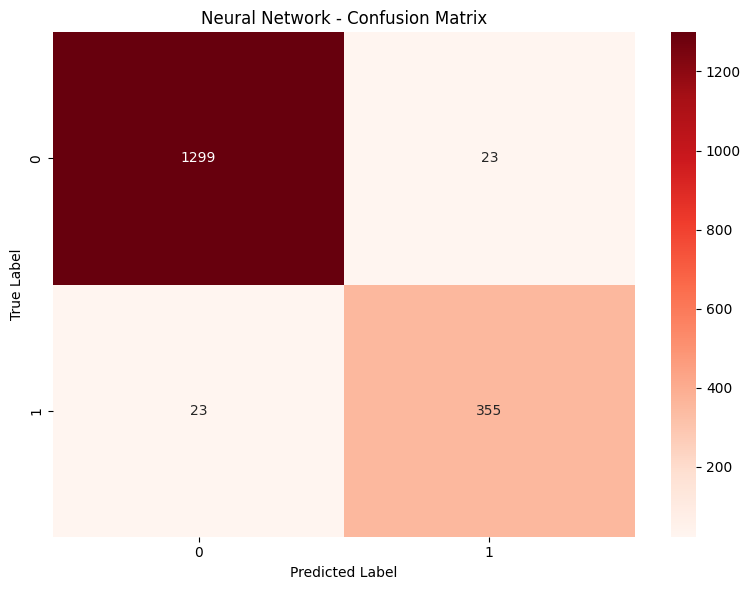


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1322
           1       0.94      0.94      0.94       378

    accuracy                           0.97      1700
   macro avg       0.96      0.96      0.96      1700
weighted avg       0.97      0.97      0.97      1700



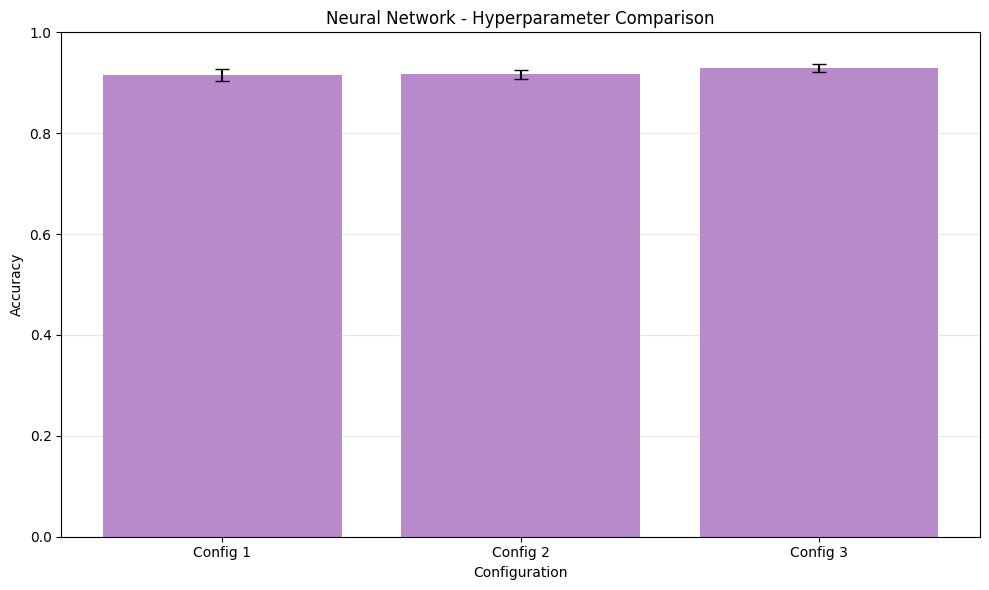

In [34]:
#Neural Network
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Setting the random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

#Loading the Data
df = pd.read_csv("train_set.csv")
X = df.drop(columns=['fetal_health'])
y = df['fetal_health'] - 1   # convert classes to 0-indexed

print(f"Training data shape: {X.shape}")
print(f"Classes: {np.unique(y.values)}")

input_size = X.shape[1]
output_size = len(np.unique(y))
k = 5

# DEFINE NEURAL NETWORK
class NNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# HYPERPARAMETER CONFIGURATIONS

configs = [
    {'hidden_size': 32, 'lr': 0.001, 'n_epochs': 60, 'batch_size': 32},
    {'hidden_size': 64, 'lr': 0.001, 'n_epochs': 60, 'batch_size': 32},
    {'hidden_size': 64, 'lr': 0.01, 'n_epochs': 60, 'batch_size': 64},
]

results = []

# TEST EACH CONFIGURATION
for config_idx, config in enumerate(configs):
    print(f"CONFIGURATION {config_idx+1}/{len(configs)}")
    print(f"Hidden: {config['hidden_size']}, LR: {config['lr']}, Batch: {config['batch_size']}")

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    fold_acc = []
    fold_prec = []
    fold_rec = []
    fold_f1 = []

    # Cross Validation Loop
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n  Fold {fold+1}/{k}")

        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # Scaling X only
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)

        # Converting into Tensors
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_fold.values, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val_fold.values, dtype=torch.long)

        train_ds = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)

        model = NNClassifier(input_size, config['hidden_size'], output_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])

        # Training Loop
        for epoch in range(config['n_epochs']):
            model.train()
            epoch_loss = 0

            for x_batch, y_batch in train_loader:
                optimizer.zero_grad()
                preds = model(x_batch)
                loss = criterion(preds, y_batch)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            if (epoch+1) % 20 == 0:
                print(f"    Epoch {epoch+1}: Loss = {epoch_loss/len(train_loader):.4f}")

        # Model Evaluation
        model.eval()
        with torch.no_grad():
            val_preds_logits = model(X_val_tensor)
            _, val_preds = torch.max(val_preds_logits, 1)

        # Metrics
        accuracy = accuracy_score(y_val_tensor.numpy(), val_preds.numpy())
        precision = precision_score(y_val_tensor.numpy(), val_preds.numpy(), average='weighted', zero_division=0)
        recall = recall_score(y_val_tensor.numpy(), val_preds.numpy(), average='weighted', zero_division=0)
        f1 = f1_score(y_val_tensor.numpy(), val_preds.numpy(), average='weighted', zero_division=0)

        # Store metrics
        fold_acc.append(accuracy)
        fold_prec.append(precision)
        fold_rec.append(recall)
        fold_f1.append(f1)

        print(f"    Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # Calculate averages for this configuration
    mean_acc = np.mean(fold_acc)
    std_acc = np.std(fold_acc)
    mean_prec = np.mean(fold_prec)
    mean_rec = np.mean(fold_rec)
    mean_f1 = np.mean(fold_f1)

    results.append({
        'config': config_idx + 1,
        'params': config,
        'accuracy': mean_acc,
        'accuracy_std': std_acc,
        'precision': mean_prec,
        'recall': mean_rec,
        'f1': mean_f1
    })

    print(f"\nConfig {config_idx+1} Average Results:")
    print(f"Accuracy:  {mean_acc:.4f} (+/- {std_acc:.4f})")
    print(f"Precision: {mean_prec:.4f}")
    print(f"Recall:    {mean_rec:.4f}")
    print(f"F1-Score:  {mean_f1:.4f}")

# BEST CONFIGURATION

print("HYPERPARAMETER TUNING RESULTS")

results_df = pd.DataFrame([{
    'Config': r['config'],
    'Hidden Size': r['params']['hidden_size'],
    'Learning Rate': r['params']['lr'],
    'Batch Size': r['params']['batch_size'],
    'Accuracy': f"{r['accuracy']:.4f} ± {r['accuracy_std']:.4f}",
    'Precision': f"{r['precision']:.4f}",
    'Recall': f"{r['recall']:.4f}",
    'F1-Score': f"{r['f1']:.4f}"
} for r in results])

print("\n", results_df.to_string(index=False))

best_idx = np.argmax([r['accuracy'] for r in results])
best_config = results[best_idx]

print("BEST CONFIGURATION")
print(f"Configuration {best_config['config']}:")
print(f"Hidden Size: {best_config['params']['hidden_size']}")
print(f"Learning Rate: {best_config['params']['lr']}")
print(f"Batch Size: {best_config['params']['batch_size']}")
print(f"\nPerformance:")
print(f"Accuracy:  {best_config['accuracy']:.4f} (+/- {best_config['accuracy_std']:.4f})")
print(f"Precision: {best_config['precision']:.4f}")
print(f"Recall:    {best_config['recall']:.4f}")
print(f"F1-Score:  {best_config['f1']:.4f}")

# TRAIN FINAL MODEL
print("TRAINING FINAL MODEL ON ENTIRE TRAINING SET")

# Scale entire dataset
scaler_final = StandardScaler()
X_scaled_final = scaler_final.fit_transform(X)

# Convert to tensors
X_tensor_final = torch.tensor(X_scaled_final, dtype=torch.float32)
y_tensor_final = torch.tensor(y.values, dtype=torch.long)

# Create DataLoader
train_ds_final = TensorDataset(X_tensor_final, y_tensor_final)
train_loader_final = DataLoader(train_ds_final, batch_size=best_config['params']['batch_size'], shuffle=True)

# Initialize final model with best hyperparameters
final_model = NNClassifier(input_size, best_config['params']['hidden_size'], output_size)
criterion_final = nn.CrossEntropyLoss()
optimizer_final = optim.Adam(final_model.parameters(), lr=best_config['params']['lr'])

# Train final model
for epoch in range(best_config['params']['n_epochs']):
    final_model.train()
    epoch_loss = 0

    for x_batch, y_batch in train_loader_final:
        optimizer_final.zero_grad()
        preds = final_model(x_batch)
        loss = criterion_final(preds, y_batch)
        loss.backward()
        optimizer_final.step()
        epoch_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: Loss = {epoch_loss/len(train_loader_final):.4f}")

# VISUALIZATIONS

# Evaluate final model for confusion matrix
final_model.eval()
with torch.no_grad():
    final_preds_logits = final_model(X_tensor_final)
    _, final_preds = torch.max(final_preds_logits, 1)

# Confusion Matrix
cm = confusion_matrix(y_tensor_final.numpy(), final_preds.numpy())
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Neural Network - Confusion Matrix')
plt.tight_layout()
plt.show()
# Classification Report
print("\nClassification Report:")
print(classification_report(y_tensor_final.numpy(), final_preds.numpy()))

#Configuration comparison
plt.figure(figsize=(10, 6))
configs_names = [f"Config {r['config']}" for r in results]
accuracies = [r['accuracy'] for r in results]
stds = [r['accuracy_std'] for r in results]

plt.bar(configs_names, accuracies, yerr=stds, capsize=5, alpha=0.7, color='#9b59b6')
plt.xlabel('Configuration')
plt.ylabel('Accuracy')
plt.title('Neural Network - Hyperparameter Comparison')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()